In [185]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [186]:
import pandas as pd
df = pd.read_csv('/content/exchange_final.csv')

In [187]:
# 변수 정의
target = df['원/달러환율_t+1'] = df['원/달러환율'].shift(-1)

features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            '실질GDP', '실질GDP성장률', '한국 10년 채권수익률', '미국 10년 채권수익률', 'vix']

In [188]:
df_filled = df.interpolate(method='linear')
df_filled = df_filled.fillna(method='ffill').fillna(method='bfill')

<ipython-input-188-76dd81b09891>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_filled = df.interpolate(method='linear')
<ipython-input-188-76dd81b09891>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_filled.fillna(method='ffill').fillna(method='bfill')


In [189]:
# 전체 길이 기준으로 분할 비율 설정
total_len = len(df_filled)
split1 = int(total_len * 0.7)
split2 = int(total_len * 0.9)

# 먼저 분할 (시계열 순서 유지)
train_df = df_filled.iloc[:split1]
val_df = df_filled.iloc[split1:split2]
test_df = df_filled.iloc[split2:]

In [190]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# 훈련 데이터로 스케일러 학습 및 변환
train_scaled_array = scaler.fit_transform(train_df[features + ['원/달러환율_t+1']])
train_scaled = pd.DataFrame(train_scaled_array, columns=features + ['원/달러환율_t+1'])
train_scaled['TIME'] = train_df['TIME'].values  # 시간 정보 복원

# 검증 데이터에 학습된 스케일러 적용
val_scaled_array = scaler.transform(val_df[features + ['원/달러환율_t+1']])
val_scaled = pd.DataFrame(val_scaled_array, columns=features + ['원/달러환율_t+1'])
val_scaled['TIME'] = val_df['TIME'].values  # 시간 정보 복원

# 테스트 데이터에 학습된 스케일러 적용
test_scaled_array = scaler.transform(test_df[features + ['원/달러환율_t+1']])
test_scaled = pd.DataFrame(test_scaled_array, columns=features + ['원/달러환율_t+1'])
test_scaled['TIME'] = test_df['TIME'].values  # 시간 정보 복원

# 입력(X), 타겟(y) 분리
X_train = train_scaled[features]
X_val = val_scaled[features]
X_test = test_scaled[features]

y_train = train_scaled['원/달러환율_t+1']
y_val = val_scaled['원/달러환율_t+1']
y_test = test_scaled['원/달러환율_t+1']

### 전진 선택법

In [191]:
# 전진선택법 실행
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

def forward_selection(X, y, max_features=None):
    selected = []
    remaining = list(X.columns)
    best_rmse = float('inf')
    history = []

    while remaining:
        scores = []
        for candidate in remaining:
            test_features = selected + [candidate]
            model = LinearRegression()
            neg_mse = cross_val_score(model, X[test_features], y,
                                      scoring='neg_mean_squared_error', cv=5).mean()
            rmse = np.sqrt(-neg_mse)
            scores.append((rmse, candidate))

        scores.sort()
        best_new_rmse, best_candidate = scores[0]

        if best_new_rmse < best_rmse:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_rmse = best_new_rmse
            history.append((list(selected), best_rmse))
        else:
            break

        if max_features and len(selected) >= max_features:
            break

    return history

forward_result = forward_selection(X_train, y_train)
selected_forward = forward_result[-1][0]
print("전진선택법 변수 :", selected_forward)

전진선택법 변수 : ['알루미늄 가격', 'vix', '유연탄 가격', '인플레이션 격차', 'WTI 유가', '외국인 투자 금액', '천연가스 가격', '니켈 가격', '한국 10년 채권수익률', '금 가격', '한국 경상수지']


### 후진 제거법

In [192]:
# 후진 제거법
def backward_elimination(X, y, min_features=1):
    selected = list(X.columns)  # 처음엔 모든 변수를 선택
    best_rmse = float('inf')
    history = []

    model = LinearRegression()
    neg_mse = cross_val_score(model, X[selected], y,
                              scoring='neg_mean_squared_error', cv=5).mean()
    best_rmse = np.sqrt(-neg_mse)
    history.append((list(selected), best_rmse))

    while len(selected) > min_features:
        scores = []
        for candidate in selected:
            reduced = list(selected)
            reduced.remove(candidate)
            model = LinearRegression()
            neg_mse = cross_val_score(model, X[reduced], y,
                                      scoring='neg_mean_squared_error', cv=5).mean()
            rmse = np.sqrt(-neg_mse)
            scores.append((rmse, candidate))

        scores.sort()
        best_new_rmse, worst_candidate = scores[0]

        if best_new_rmse <= best_rmse:  # 개선되거나 같으면 제거
            selected.remove(worst_candidate)
            best_rmse = best_new_rmse
            history.append((list(selected), best_rmse))
        else:
            break

    return history

# 사용 예시
backward_result = backward_elimination(X_train, y_train)
selected_backward = backward_result[-1][0]
print("후진제거법 변수 :", selected_backward)


후진제거법 변수 : ['경제 심리 지수', '한국 기준 금리', '한국 실업률', '한국 주가지수', '미국 주가지수', '두바이 유가', 'Brent 유가', '유연탄 가격', '철광석 가격', '니켈 가격', '금 가격', '외국인 투자 금액', '옥수수 가격', '소맥 가격', '인플레이션 격차', '실질GDP', '한국 10년 채권수익률', 'vix']


### 단계 선택법

In [193]:
# 단계 선택법
def stepwise_selection(X, y, max_features=None):
    selected = []
    remaining = list(X.columns)
    best_rmse = float('inf')
    history = []

    while True:
        # 전진단계
        forward_scores = []
        for candidate in remaining:
            model = LinearRegression()
            neg_mse = cross_val_score(model, X[selected + [candidate]], y,
                                      scoring='neg_mean_squared_error', cv=5).mean()
            rmse = np.sqrt(-neg_mse)
            forward_scores.append((rmse, candidate))

        forward_scores.sort()
        best_forward_rmse, best_forward_var = forward_scores[0]

        if best_forward_rmse < best_rmse:
            selected.append(best_forward_var)
            remaining.remove(best_forward_var)
            best_rmse = best_forward_rmse
            history.append((list(selected), best_rmse))
        else:
            break

        # 후진단계 (2개 이상일 때만 수행)
        if len(selected) > 1:
            backward_scores = []
            for candidate in selected:
                reduced = list(selected)
                reduced.remove(candidate)
                model = LinearRegression()
                neg_mse = cross_val_score(model, X[reduced], y,
                                          scoring='neg_mean_squared_error', cv=5).mean()
                rmse = np.sqrt(-neg_mse)
                backward_scores.append((rmse, candidate))

            worst_rmse, worst_var = min(backward_scores)
            if worst_rmse < best_rmse:
                selected.remove(worst_var)
                remaining.append(worst_var)
                best_rmse = worst_rmse
                history.append((list(selected), best_rmse))

        if max_features and len(selected) >= max_features:
            break

    return history

stepwise_result = stepwise_selection(X_train, y_train)
selected_stepwise = stepwise_result[-1][0]
print("단계선택법 변수 :", selected_stepwise)


단계선택법 변수 : ['알루미늄 가격', 'vix', '유연탄 가격', 'WTI 유가', '외국인 투자 금액', '천연가스 가격', '니켈 가격', '한국 10년 채권수익률', '미국 10년 채권수익률']


### 랜덤시드 고정

In [194]:
import random
import numpy as np
import tensorflow as tf
import os

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# GRU

- 시계열 시퀀스 형태 변환 함수

In [195]:
import numpy as np

def create_sequences(df, feature_cols, target_col, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[feature_cols].iloc[i:i+seq_length].values)
        y.append(df[target_col].iloc[i+seq_length])  # t+1 예측
    return np.array(X), np.array(y)


## 전진 선택법

- 피처 준비 및 시퀀스 데이터 생성

In [217]:
# 피처 리스트
feature_cols = selected_forward
target_col = '원/달러환율_t+1'
seq_length = 12

# 시퀀스 데이터 생성
X_train_seq, y_train_seq = create_sequences(train_scaled, feature_cols, target_col, seq_length)
X_val_seq, y_val_seq = create_sequences(val_scaled, feature_cols, target_col, seq_length)
X_test_seq, y_test_seq = create_sequences(test_scaled, feature_cols, target_col, seq_length)

### 기본 모델 (과적합 판단)

In [214]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

set_seed(42)

def build_basic_gru(input_shape):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # 환율 예측
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

model = build_basic_gru(input_shape=(seq_length, len(feature_cols)))
model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# 학습
history = model.fit(X_train_seq, y_train_seq,
                    validation_data=(X_val_seq, y_val_seq),
                    epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_299"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_298 (GRU)                   │ (None, 64)             │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_551 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_684 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0627 - root_mean_squared_error: 0.2500 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1370
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0323 - root_mean_squared_error: 0.1795 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1578
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1597
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0209 - root_mean_squared_error: 0.1446 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1808
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


- 예측값 평가 및 실제 vs 예측 그래프

In [215]:
# 예측
y_pred_scaled = model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

total_feature_count = scaler.n_features_in_  # scaler가 학습한 총 컬럼 수

# 역변환
# y_pred_scaled: (N,) → (N, 1)
# 전체 컬럼 수만큼 0 만들고 마지막 열만 예측값
y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]


# =지표 계산 (역변환된 값 기준)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
✅ RMSE: 156.3043
✅ MAE : 147.6577
✅ MSE : 24431.0404
✅ R²  : -13.2313


In [216]:
# ✅ 검증셋 성능 지표
val_pred_scaled = model.predict(X_val_seq).flatten()
val_true_scaled = y_val_seq

val_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(val_pred_scaled), total_feature_count - 1)), val_pred_scaled.reshape(-1, 1)])
)[:, -1]

val_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(val_true_scaled), total_feature_count - 1)), val_true_scaled.reshape(-1, 1)])
)[:, -1]

val_rmse = np.sqrt(mean_squared_error(val_true, val_pred))
val_mae = mean_absolute_error(val_true, val_pred)
val_mse = mean_squared_error(val_true, val_pred)
val_r2 = r2_score(val_true, val_pred)

print(f"📊 검증 RMSE: {val_rmse:.4f}")
print(f"📊 검증 MAE : {val_mae:.4f}")
print(f"📊 검증 MSE : {val_mse:.4f}")
print(f"📊 검증 R²  : {val_r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
📊 검증 RMSE: 73.7905
📊 검증 MAE : 59.9328
📊 검증 MSE : 5445.0341
📊 검증 R²  : -0.9647


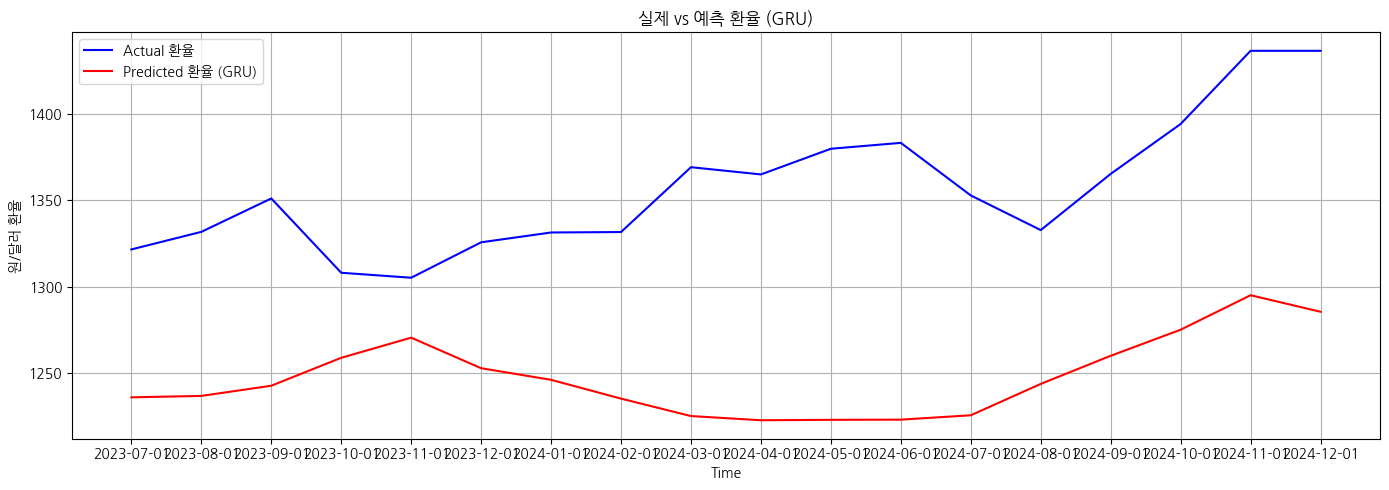

In [93]:
import matplotlib.pyplot as plt

# 시계열 타임스탬프 가져오기 (시퀀스에 맞춰 뒤로 밀림)
time_index = test_scaled['TIME'].values[seq_length:]

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (GRU)", color='red')
plt.xlabel("Time")
plt.ylabel("원/달러 환율")
plt.title("실제 vs 예측 환율 (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 과적합 개선

In [209]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_regularized_gru(input_shape):
    model = Sequential()
    model.add(GRU(48, input_shape=input_shape,
                  kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))  # 기본 0.2보다 높임
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,  # 빠르게 과적합 차단
    restore_best_weights=True
)

In [210]:
# 학습
history = model.fit(X_train_seq, y_train_seq,
                    validation_data=(X_val_seq, y_val_seq),
                    epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0872 - root_mean_squared_error: 0.2603 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1290
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0736 - root_mean_squared_error: 0.2348 - val_loss: 0.0436 - val_root_mean_squared_error: 0.1608
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0626 - root_mean_squared_error: 0.2119 - val_loss: 0.0506 - val_root_mean_squared_error: 0.1833
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0544 - root_mean_squared_error: 0.1940 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2250


In [211]:
# 예측
y_pred_scaled = model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

total_feature_count = scaler.n_features_in_  # scaler가 학습한 총 컬럼 수

# 역변환
# y_pred_scaled: (N,) → (N, 1)
# 전체 컬럼 수만큼 0 만들고 마지막 열만 예측값
y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]


# =지표 계산 (역변환된 값 기준)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
✅ RMSE: 179.6118
✅ MAE : 177.1509
✅ MSE : 32260.4148
✅ R²  : -21.7383


In [212]:
# ✅ 검증셋 성능 지표
val_pred_scaled = model.predict(X_val_seq).flatten()
val_true_scaled = y_val_seq

val_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(val_pred_scaled), total_feature_count - 1)), val_pred_scaled.reshape(-1, 1)])
)[:, -1]

val_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(val_true_scaled), total_feature_count - 1)), val_true_scaled.reshape(-1, 1)])
)[:, -1]

val_rmse = np.sqrt(mean_squared_error(val_true, val_pred))
val_mae = mean_absolute_error(val_true, val_pred)
val_mse = mean_squared_error(val_true, val_pred)
val_r2 = r2_score(val_true, val_pred)

print(f"📊 검증 RMSE: {val_rmse:.4f}")
print(f"📊 검증 MAE : {val_mae:.4f}")
print(f"📊 검증 MSE : {val_mse:.4f}")
print(f"📊 검증 R²  : {val_r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
📊 검증 RMSE: 69.4600
📊 검증 MAE : 56.4831
📊 검증 MSE : 4824.6899
📊 검증 R²  : -1.1254


실험	주요 변경	테스트 RMSE	과적합 완화 여부

① 기본 모델	-	115.04	🔵 가장 안정적

② Dropout↑ + L2	모델 단순화	179.6	❌ 더 악화됨

③ 시퀀스 6개월	정보 단축	156.3	❌ 여전히 과적합

④ Optuna	구조 최적화	155.6	❌ 과적합

### OPTUNA 하이퍼파라미터 튜닝

In [36]:
%%capture
!pip install optuna

In [207]:
import optuna
from tensorflow.keras.optimizers import Adam, RMSprop

# 튜닝할 구조
def build_gru_model(trial, input_shape):
    set_seed(42)  # 시드 고정

    units = trial.suggest_int('units', 32, 128)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = RMSprop(learning_rate=lr)

    model = Sequential()
    model.add(GRU(units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# 성능 평가 (기준 RMSE)
def objective(trial):

    model = build_gru_model(trial, input_shape=(seq_length, len(feature_cols)))

    early_stop = EarlyStopping(
        monitor='val_loss',  # 또는 'val_root_mean_squared_error'
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=20,
        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
        callbacks=[early_stop],
        verbose=0
    )

    # 검증셋에서 RMSE 직접 계산 (metrics[1]이 RMSE로 설정되어 있음)
    val_loss, val_rmse = model.evaluate(X_val_seq, y_val_seq, verbose=0)

    return val_rmse  # 🎯 이제 RMSE가 최적화 대상!

In [95]:
# optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # 30회 시도 (더 늘릴 수도 있음)

print("✅ Best params:", study.best_params)
print("✅ Best validation loss (MSE):", study.best_value)

[I 2025-04-29 14:45:07,551] A new study created in memory with name: no-name-6d324bea-fc95-4ae4-b3f1-683962fdf8fc
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-29 14:45:12,741] Trial 0 finished with value: 0.19685113430023193 and parameters: {'units': 118, 'dropout': 0.29596344966124166, 'learning_rate': 0.003946640014919258, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 0 with value: 0.19685113430023193.
[I 2025-04-29 14:45:17,398] Trial 1 finished with value: 0.10204211622476578 and parameters: {'units': 34, 'dropout': 0.4636689545695689, 'learning_rate': 0.001707493782488084, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 1 with value: 0.10204211622476578.
[I 2025-04-29 14:45:20,796] Trial 2 finished with value: 0.1

✅ Best params: {'units': 89, 'dropout': 0.23922125860189758, 'learning_rate': 0.00042149530949754134, 'optimizer': 'rmsprop', 'batch_size': 32}
✅ Best validation loss (MSE): 0.096157006919384


In [208]:
# 가장 좋은 모델 학습
best_params = study.best_params
final_model = build_gru_model(optuna.trial.FixedTrial(best_params), input_shape=(seq_length, len(feature_cols)))
final_model.fit(X_train_seq, y_train_seq,
                validation_data=(X_val_seq, y_val_seq),
                epochs=50,
                batch_size=best_params['batch_size'],
                verbose=1)

- [모델로 예측 후 역변환한 평가지표]

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측 (scaled 상태)
y_pred_scaled = final_model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

# 역변환 (전체 feature 수 기준으로 0 채우기)
total_feature_count = scaler.n_features_in_

y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]

# 지표 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
✅ RMSE: 155.6327
✅ MAE : 148.7066
✅ MSE : 24221.5440
✅ R²  : -16.0722


+ [실제 vs 예측 환율 그래프]

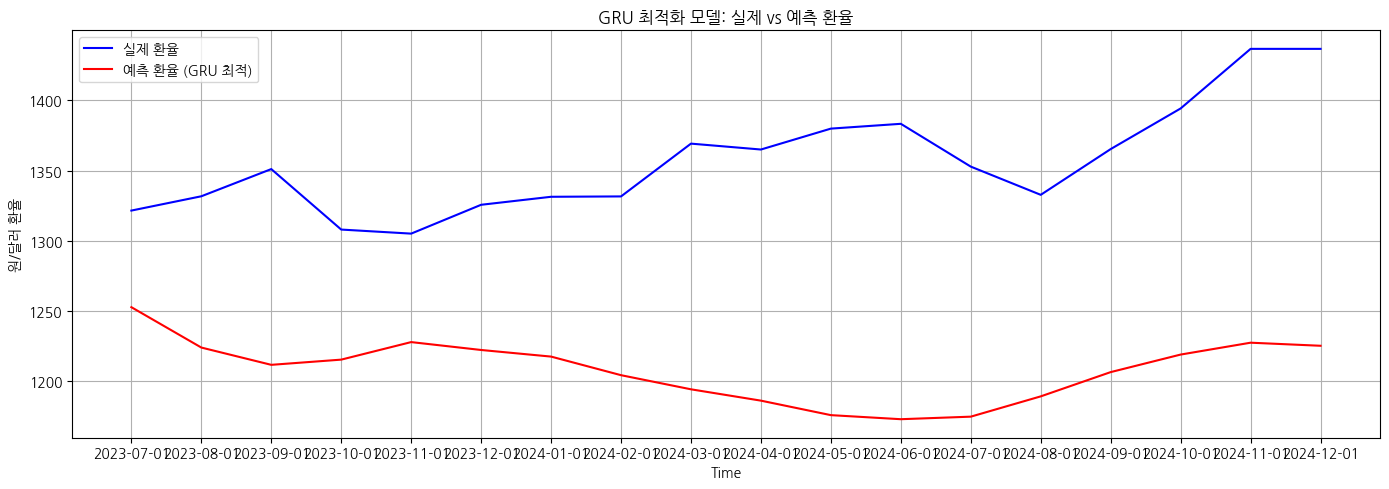

In [98]:
import matplotlib.pyplot as plt

time_index = test_scaled['TIME'].values[seq_length:]

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="실제 환율", color='blue')
plt.plot(time_index, y_pred, label="예측 환율 (GRU 최적)", color='red')
plt.xlabel("Time")
plt.ylabel("원/달러 환율")
plt.title("GRU 최적화 모델: 실제 vs 예측 환율")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

➡︎ 기본 모델이 가장 나음

## 후진 제거법

- 피처 준비 및 시퀀스 데이터 생성

In [109]:
# 피처 리스트
feature_cols = selected_backward
target_col = '원/달러환율_t+1'
seq_length = 12

# 시퀀스 데이터 생성
X_train_seq, y_train_seq = create_sequences(train_scaled, feature_cols, target_col, seq_length)
X_val_seq, y_val_seq = create_sequences(val_scaled, feature_cols, target_col, seq_length)
X_test_seq, y_test_seq = create_sequences(test_scaled, feature_cols, target_col, seq_length)

### 기본 모델

In [113]:
set_seed(42)  # 재현성

model = build_basic_gru(input_shape=(seq_length, len(feature_cols)))

early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model.fit(X_train_seq, y_train_seq,
          validation_data=(X_val_seq, y_val_seq),
          epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1052 - root_mean_squared_error: 0.3236 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1525
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0535 - root_mean_squared_error: 0.2309 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1642
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0470 - root_mean_squared_error: 0.2166 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1718
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0303 - root_mean_squared_error: 0.1738 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1710
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0285 - root_mean_squared_error: 0.1686 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1748
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0256 - root_mean_squared_error: 0.1599 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1736
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0242 - root_mean_squar

In [114]:
# 예측
y_pred_scaled = model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

total_feature_count = scaler.n_features_in_  # scaler가 학습한 총 컬럼 수

# 역변환
# y_pred_scaled: (N,) → (N, 1)
# 전체 컬럼 수만큼 0 만들고 마지막 열만 예측값
y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]


# =지표 계산 (역변환된 값 기준)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
✅ RMSE: 258.3243
✅ MAE : 255.3881
✅ MSE : 66731.4411
✅ R²  : -46.0348


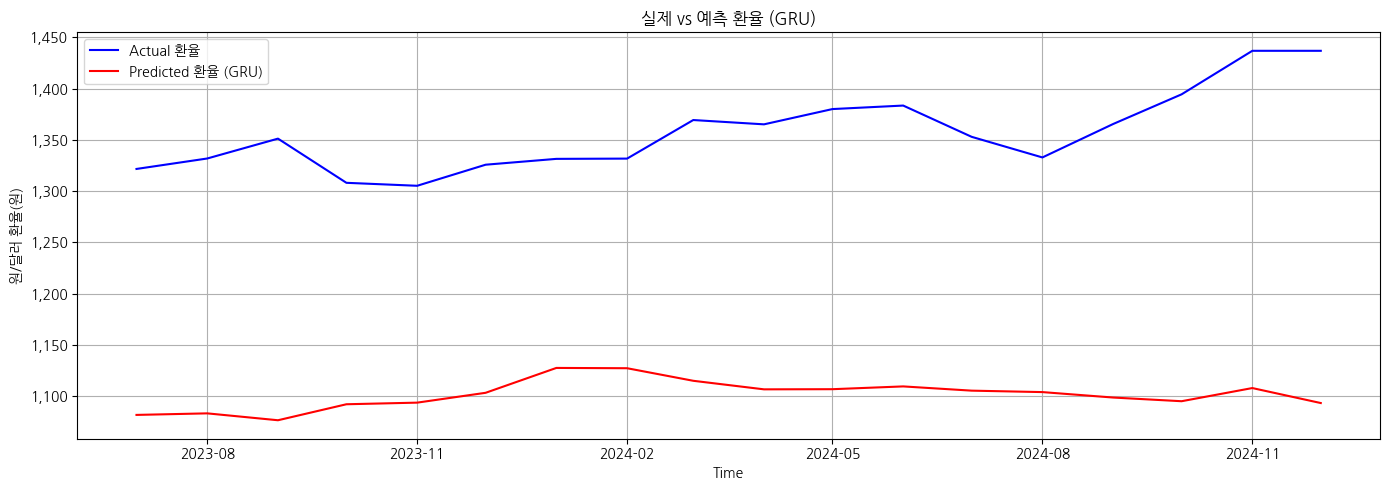

In [105]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (GRU)", color='red')

# x축: 연도 + 월 표시 (간격은 분기별)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월마다 눈금
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### OPTUNA 하이퍼파라미터 튜닝

In [116]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop

def build_gru_model(trial, input_shape):
    set_seed(42)

    units = trial.suggest_int('units', 32, 128)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    optimizer = Adam(learning_rate=lr) if optimizer_name == 'adam' else RMSprop(learning_rate=lr)

    model = Sequential([
        GRU(units, input_shape=input_shape),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

def objective(trial):
    model = build_gru_model(trial, input_shape=(seq_length, len(feature_cols)))

    early_stop = EarlyStopping(
        monitor='val_loss',  # 또는 'val_root_mean_squared_error'
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=20,
        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
        callbacks=[early_stop],
        verbose=0
    )

    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)[0]
    return val_loss


In [117]:
# 튜닝 시작
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # 필요시 n_trials 늘릴 수 있어

# 결과 출력
print("✅ Best params:", study.best_params)
print("✅ Best validation loss (MSE):", study.best_value)

[I 2025-04-29 15:00:28,271] A new study created in memory with name: no-name-934fc1e9-4ae1-451b-8a36-75a7c19182b7
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-29 15:00:37,362] Trial 0 finished with value: 0.026412369683384895 and parameters: {'units': 56, 'dropout': 0.10157918602777843, 'learning_rate': 0.0012030311562724186, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.026412369683384895.
[I 2025-04-29 15:00:40,937] Trial 1 finished with value: 0.037481632083654404 and parameters: {'units': 56, 'dropout': 0.30191763040187763, 'learning_rate': 0.004560269993429366, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 0 with value: 0.026412369683384895.
[I 2025-04-29 15:00:47,637] Trial 2 finished with value: 0

✅ Best params: {'units': 99, 'dropout': 0.2544569373249858, 'learning_rate': 0.002257094523461185, 'optimizer': 'rmsprop', 'batch_size': 32}
✅ Best validation loss (MSE): 0.009005439467728138


In [121]:
# 가장 좋은 모델 학습
best_params = study.best_params
final_model = build_gru_model(optuna.trial.FixedTrial(best_params), input_shape=(seq_length, len(feature_cols)))
early_stop = EarlyStopping(
  monitor='val_loss',  # 또는 'val_root_mean_squared_error'
  patience=5,
  restore_best_weights=True,
  verbose=0
)
final_model.fit(X_train_seq, y_train_seq,
                validation_data=(X_val_seq, y_val_seq),
                epochs=50,
                batch_size=best_params['batch_size'],
                callbacks=[early_stop],
                verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.3294 - root_mean_squared_error: 0.5674 - val_loss: 0.1009 - val_root_mean_squared_error: 0.3177
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0581 - root_mean_squared_error: 0.2408 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2773
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0466 - root_mean_squared_error: 0.2154 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2584
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0361 - root_mean_squared_error: 0.1896 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0309 - root_mean_squared_error: 0.1726 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1747
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0285 - root_mean_squared_error: 0.1682 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0201 - root_mean_squar

- [모델로 예측 후 역변환한 평가지표]

In [122]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측 (scaled 상태)
y_pred_scaled = final_model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

# 역변환 (전체 feature 수 기준으로 0 채우기)
total_feature_count = scaler.n_features_in_

y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]

# 지표 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
✅ RMSE: 144.5843
✅ MAE : 139.5443
✅ MSE : 20904.6102
✅ R²  : -13.7343


+ [실제 vs 예측 환율 그래프]

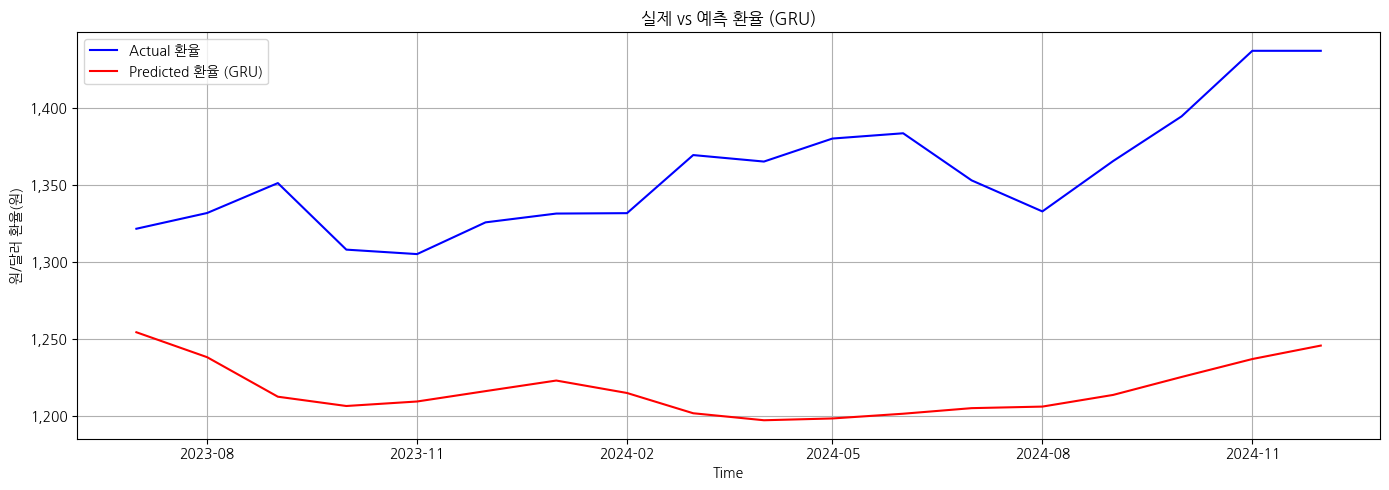

In [124]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (GRU)", color='red')

# x축: 연도 + 월 표시 (간격은 분기별)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월마다 눈금
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### best model 과적합 판단

In [223]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

def build_gru_model_with_fixed_params(input_shape):
    set_seed(42)
    model = Sequential()
    model.add(GRU(99, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2544569373249858))
    model.add(Dense(1))

    optimizer = RMSprop(learning_rate=0.002257094523461185)
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [224]:
# 학습
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model = build_gru_model_with_fixed_params(input_shape=(seq_length, len(feature_cols)))

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - loss: 0.1793 - root_mean_squared_error: 0.4180 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2204
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0396 - root_mean_squared_error: 0.1987 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1389
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0256 - root_mean_squared_error: 0.1589 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1634
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0240 - root_mean_squared_error: 0.1543 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0193 - root_mean_squared_error: 0.1377 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1522
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0175 - root_mean_squared_error: 0.1313 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0146 - roo

In [225]:
# 검증셋 예측
y_val_pred_scaled = model.predict(X_val_seq).flatten()
total_feature_count = scaler.n_features_in_

# 역변환
y_val_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_val_pred_scaled), total_feature_count - 1)), y_val_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_val_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_val_seq), total_feature_count - 1)), y_val_seq.reshape(-1, 1)])
)[:, -1]

# 지표 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
val_mae = mean_absolute_error(y_val_true, y_val_pred)
val_mse = mean_squared_error(y_val_true, y_val_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

print(f"📊 검증 RMSE: {val_rmse:.4f}")
print(f"📊 검증 MAE : {val_mae:.4f}")
print(f"📊 검증 MSE : {val_mse:.4f}")
print(f"📊 검증 R²  : {val_r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
📊 검증 RMSE: 62.2590
📊 검증 MAE : 53.5570
📊 검증 MSE : 3876.1796
📊 검증 R²  : -0.7076


In [226]:
# 테스트셋 예측
y_test_pred_scaled = model.predict(X_test_seq).flatten()

# 역변환
y_test_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_test_pred_scaled), total_feature_count - 1)), y_test_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_test_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_test_seq), total_feature_count - 1)), y_test_seq.reshape(-1, 1)])
)[:, -1]

# 지표 계산
test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_mse = mean_squared_error(y_test_true, y_test_pred)
test_r2 = r2_score(y_test_true, y_test_pred)

print(f"✅ RMSE: {test_rmse:.4f}")
print(f"✅ MAE : {test_mae:.4f}")
print(f"✅ MSE : {test_mse:.4f}")
print(f"✅ R²  : {test_r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
✅ RMSE: 150.5835
✅ MAE : 145.7762
✅ MSE : 22675.3884
✅ R²  : -14.9824


## 단계 선택법

In [227]:
# 피처 리스트
feature_cols = selected_stepwise
target_col = '원/달러환율_t+1'
seq_length = 12

# 시퀀스 데이터 생성
X_train_seq, y_train_seq = create_sequences(train_scaled, feature_cols, target_col, seq_length)
X_val_seq, y_val_seq = create_sequences(val_scaled, feature_cols, target_col, seq_length)
X_test_seq, y_test_seq = create_sequences(test_scaled, feature_cols, target_col, seq_length)

### 기본 모델

In [228]:
set_seed(42)

model = build_basic_gru(input_shape=(seq_length, len(feature_cols)))

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0533 - root_mean_squared_error: 0.2306 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0914
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0251 - root_mean_squared_error: 0.1580 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0198 - root_mean_squared_error: 0.1404 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0161 - root_mean_squared_error: 0.1266 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0187 - root_mean_squared_error: 0.1364 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0158 - root_mean_squared_error: 0.1256 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0161 - root_mean_squa

In [230]:
# 예측
y_pred_scaled = model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

total_feature_count = scaler.n_features_in_  # scaler가 학습한 총 컬럼 수

# 역변환
# y_pred_scaled: (N,) → (N, 1)
# 전체 컬럼 수만큼 0 만들고 마지막 열만 예측값
y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]


# =지표 계산 (역변환된 값 기준)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
✅ RMSE: 59.2851
✅ MAE : 49.7352
✅ MSE : 3514.7280
✅ R²  : -1.4773


In [231]:
# ✅ 검증셋 성능 지표
val_pred_scaled = model.predict(X_val_seq).flatten()
val_true_scaled = y_val_seq

val_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(val_pred_scaled), total_feature_count - 1)), val_pred_scaled.reshape(-1, 1)])
)[:, -1]

val_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(val_true_scaled), total_feature_count - 1)), val_true_scaled.reshape(-1, 1)])
)[:, -1]

val_rmse = np.sqrt(mean_squared_error(val_true, val_pred))
val_mae = mean_absolute_error(val_true, val_pred)
val_mse = mean_squared_error(val_true, val_pred)
val_r2 = r2_score(val_true, val_pred)

print(f"📊 검증 RMSE: {val_rmse:.4f}")
print(f"📊 검증 MAE : {val_mae:.4f}")
print(f"📊 검증 MSE : {val_mse:.4f}")
print(f"📊 검증 R²  : {val_r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
📊 검증 RMSE: 39.6934
📊 검증 MAE : 32.3370
📊 검증 MSE : 1575.5697
📊 검증 R²  : 0.3059


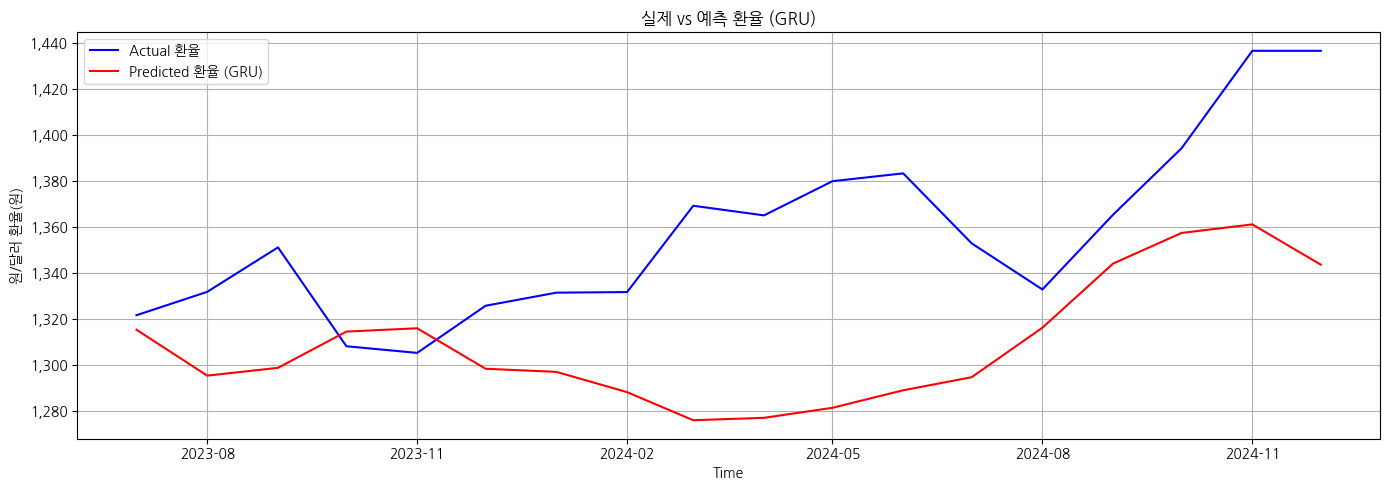

In [232]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (GRU)", color='red')

# x축: 연도 + 월 표시 (간격은 분기별)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월마다 눈금
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

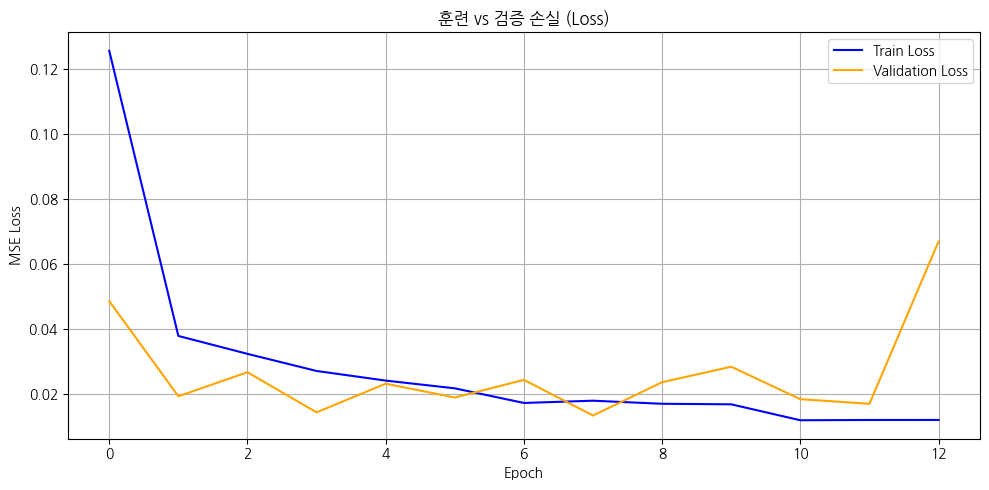

In [233]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('훈련 vs 검증 손실 (Loss)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

=> 훈련 손실(Train Loss)은 지속적으로 감소했고, 검증 손실(Validation Loss)은 중반까지는 함께 감소했으나,

후반부에 급격히 상승하는 과적합 경향이 나타났습니다.

하지만 EarlyStopping 기법을 적용하여 검증 손실이 최소였던 시점의 가중치를 복원했기 때문에,

최종적으로는 과적합 없이 일반화 성능이 유지된 모델


**결론**

검증 손실이 후반에 상승하며 과적합 경향을 보였지만, EarlyStopping을 통해 최적 시점의 가중치로 복원되어 일반화 성능은 유지됨.

(즉, EarlyStopping 적용으로 과적합 방지, 최적 성능 시점에서 학습 종료됨.)

### OPTUNA 하이퍼파라미터 튜닝

In [131]:
def build_gru_model(trial, input_shape):
    set_seed(42)

    units = trial.suggest_int('units', 32, 128)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    optimizer = Adam(learning_rate=lr) if optimizer_name == 'adam' else RMSprop(learning_rate=lr)

    model = Sequential([
        GRU(units, input_shape=input_shape),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

def objective(trial):
    model = build_gru_model(trial, input_shape=(seq_length, len(feature_cols)))

    early_stop = EarlyStopping(
        monitor='val_loss',  # 또는 'val_root_mean_squared_error'
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=20,  # 빠른 탐색
        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
        callbacks=[early_stop],
        verbose=0
    )

    _, val_rmse = model.evaluate(X_val_seq, y_val_seq, verbose=0) # rmse 기준
    return val_rmse


In [132]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("✅ Best params:", study.best_params)
print("✅ Best RMSE (val):", study.best_value)

[I 2025-04-29 15:07:15,360] A new study created in memory with name: no-name-6ebf532f-a895-469a-9eef-d187e158b483
[I 2025-04-29 15:07:21,123] Trial 0 finished with value: 0.08360552042722702 and parameters: {'units': 91, 'dropout': 0.4715166489904279, 'learning_rate': 0.005618447905752529, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.08360552042722702.
[I 2025-04-29 15:07:26,077] Trial 1 finished with value: 0.09409139305353165 and parameters: {'units': 42, 'dropout': 0.19554823339332394, 'learning_rate': 0.001745224276740123, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.08360552042722702.
[I 2025-04-29 15:07:32,111] Trial 2 finished with value: 0.08069189637899399 and parameters: {'units': 93, 'dropout': 0.3619313179876419, 'learning_rate': 0.0024117481313531953, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 2 with value: 0.08069189637899399.
[I 2025-04-29 15:07:37,249] Trial 3 finished with value: 0.10851450264453888 and param

✅ Best params: {'units': 52, 'dropout': 0.39819356549370766, 'learning_rate': 0.00013164887667669264, 'optimizer': 'rmsprop', 'batch_size': 16}
✅ Best RMSE (val): 0.06755542010068893


In [133]:
# 가장 좋은 모델 학습
best_params = study.best_params
final_model = build_gru_model(optuna.trial.FixedTrial(best_params), input_shape=(seq_length, len(feature_cols)))

early_stop = EarlyStopping(
        monitor='val_loss',  # 또는 'val_root_mean_squared_error'
        patience=5,
        restore_best_weights=True,
        verbose=0
)
final_model.fit(X_train_seq, y_train_seq,
                validation_data=(X_val_seq, y_val_seq),
                epochs=50,
                batch_size=best_params['batch_size'],
                callbacks=[early_stop],
                verbose=1)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.2576 - root_mean_squared_error: 0.5075 - val_loss: 0.0966 - val_root_mean_squared_error: 0.3107
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1871 - root_mean_squared_error: 0.4324 - val_loss: 0.0557 - val_root_mean_squared_error: 0.2360
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1315 - root_mean_squared_error: 0.3625 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1721
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0907 - root_mean_squared_error: 0.3009 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0643 - root_mean_squared_error: 0.2533 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0664 - root_mean_squared_error: 0.2569 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss:

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측 (scaled 상태)
y_pred_scaled = final_model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

# 역변환 (전체 feature 수 기준으로 0 채우기)
total_feature_count = scaler.n_features_in_

y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]

# 지표 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
✅ RMSE: 118.2159
✅ MAE : 111.8263
✅ MSE : 13974.9909
✅ R²  : -8.8501


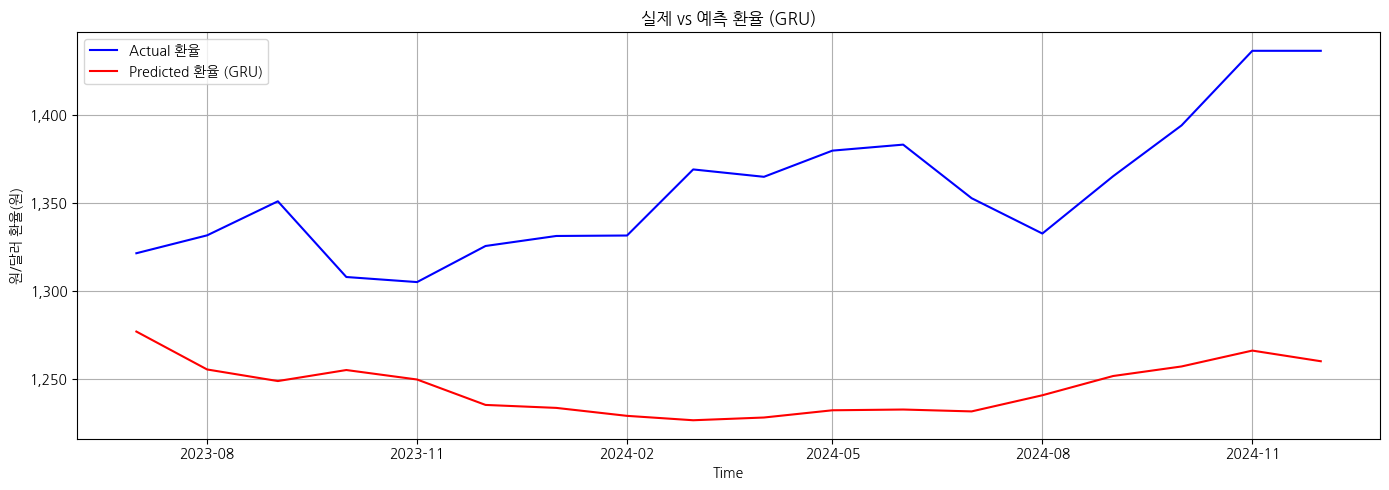

In [135]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (GRU)", color='red')

# x축: 연도 + 월 표시 (간격은 분기별)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월마다 눈금
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mini Transformer

## 전진 선택법

In [218]:
# 피처 리스트
feature_cols = selected_forward
target_col = '원/달러환율_t+1'
seq_length = 12

# 시퀀스 데이터 생성
X_train_seq, y_train_seq = create_sequences(train_scaled, feature_cols, target_col, seq_length)
X_val_seq, y_val_seq = create_sequences(val_scaled, feature_cols, target_col, seq_length)
X_test_seq, y_test_seq = create_sequences(test_scaled, feature_cols, target_col, seq_length)

### 기본 모델

In [219]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_basic_transformer(input_shape):
    set_seed(42)

    inputs = tf.keras.Input(shape=input_shape)

    # Positional Encoding
    x = layers.Dense(64)(inputs)
    x = layers.LayerNormalization()(x)

    # Transformer block
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    ff_output = layers.Dense(64, activation='relu')(x)
    x = layers.Add()([x, ff_output])
    x = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [220]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model = build_basic_transformer(input_shape=(seq_length, len(feature_cols)))
# 학습
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - loss: 0.7067 - root_mean_squared_error: 0.8328 - val_loss: 0.0805 - val_root_mean_squared_error: 0.2838
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.1068 - root_mean_squared_error: 0.3232 - val_loss: 0.3311 - val_root_mean_squared_error: 0.5754
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0735 - root_mean_squared_error: 0.2705 - val_loss: 0.2239 - val_root_mean_squared_error: 0.4732
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0347 - root_mean_squared_error: 0.1861 - val_loss: 0.0951 - val_root_mean_squared_error: 0.3084
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0160 - root_mean_squared_error: 0.1262 - val_loss: 0.1325 - val_root_mean_squared_error: 0.3640
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0171 - root_mean_squared_error: 0.1305 - val_loss: 0.1072 - val_root_mean_squared_error: 0.3274
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0096 - roo

In [221]:
# 예측
y_pred_scaled = model.predict(X_test_seq).flatten()
total_feature_count = scaler.n_features_in_

# 역변환
y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_test_seq), total_feature_count - 1)), y_test_seq.reshape(-1, 1)])
)[:, -1]

# 성능 지표
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
✅ RMSE: 149.1724
✅ MAE : 138.4083
✅ MSE : 22252.4121
✅ R²  : -14.6843


In [222]:
# 🔁 검증셋 예측
y_val_pred_scaled = model.predict(X_val_seq).flatten()

# 🔁 검증셋 역변환
y_val_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_val_pred_scaled), total_feature_count - 1)), y_val_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_val_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_val_seq), total_feature_count - 1)), y_val_seq.reshape(-1, 1)])
)[:, -1]

# 📊 성능 지표 계산
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
val_mae = mean_absolute_error(y_val_true, y_val_pred)
val_mse = mean_squared_error(y_val_true, y_val_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

print(f"📊 검증 RMSE: {val_rmse:.4f}")
print(f"📊 검증 MAE : {val_mae:.4f}")
print(f"📊 검증 MSE : {val_mse:.4f}")
print(f"📊 검증 R²  : {val_r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
📊 검증 RMSE: 152.8448
📊 검증 MAE : 126.1422
📊 검증 MSE : 23361.5306
📊 검증 R²  : -9.2914


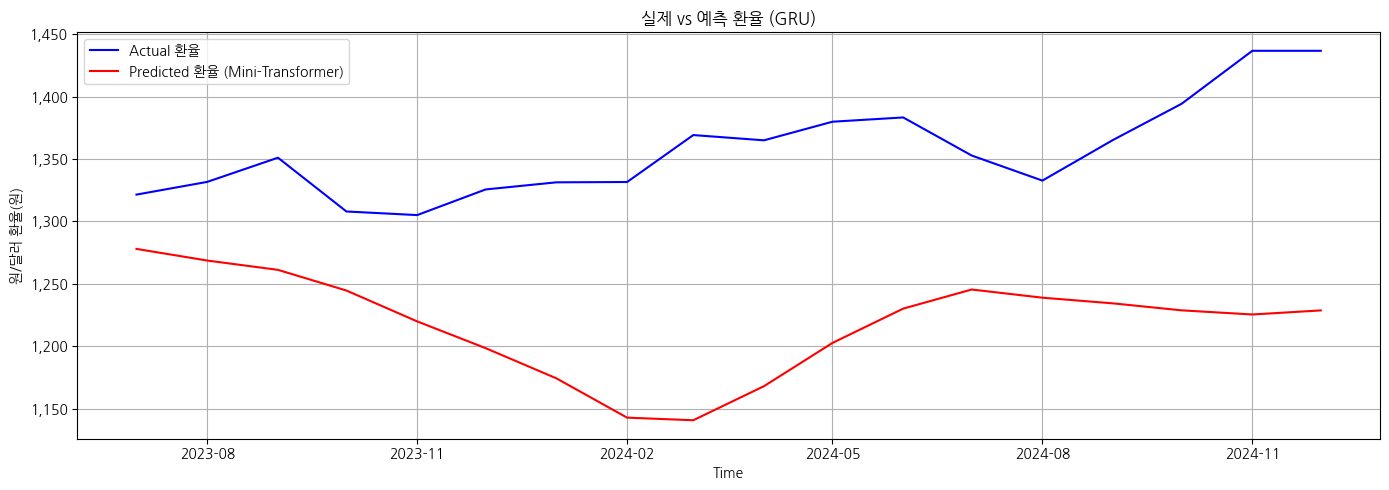

In [144]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (Mini-Transformer)", color='red')

# x축: 연도 + 월 표시 (간격은 분기별)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월마다 눈금
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### OPTUNA 하이퍼파라미터 튜닝

In [148]:
def build_transformer_model(trial, input_shape):
    set_seed(42)

    num_heads = trial.suggest_int('num_heads', 1, 4)
    key_dim = trial.suggest_int('key_dim', 8, 64)
    ff_units = trial.suggest_int('ff_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    x = layers.LayerNormalization()(x)

    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ff = layers.Dense(x.shape[-1], activation='relu')(x)
    ff = layers.Dropout(dropout_rate)(ff)
    x = layers.Add()([x, ff])
    x = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [149]:
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    model = build_transformer_model(trial, input_shape=(seq_length, len(feature_cols)))

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    _, val_rmse = model.evaluate(X_val_seq, y_val_seq, verbose=0)
    return val_rmse

In [150]:
import optuna

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("✅ Best params:", study.best_params)
print("✅ Best RMSE (val):", study.best_value)

[I 2025-04-29 15:27:48,068] A new study created in memory with name: no-name-dcd92bef-7847-4009-adb6-bff09c7a6a7c
[I 2025-04-29 15:27:55,079] Trial 0 finished with value: 0.14012707769870758 and parameters: {'num_heads': 1, 'key_dim': 51, 'ff_units': 123, 'dropout': 0.1607554987779206, 'learning_rate': 0.00615801741316262, 'batch_size': 64}. Best is trial 0 with value: 0.14012707769870758.
[I 2025-04-29 15:28:05,807] Trial 1 finished with value: 0.1571151465177536 and parameters: {'num_heads': 4, 'key_dim': 64, 'ff_units': 67, 'dropout': 0.29920275744400926, 'learning_rate': 0.00033426634620056344, 'batch_size': 64}. Best is trial 0 with value: 0.14012707769870758.
[I 2025-04-29 15:28:12,459] Trial 2 finished with value: 0.14904266595840454 and parameters: {'num_heads': 1, 'key_dim': 35, 'ff_units': 95, 'dropout': 0.47240783632810424, 'learning_rate': 0.002799899476212195, 'batch_size': 64}. Best is trial 0 with value: 0.14012707769870758.
[I 2025-04-29 15:28:17,777] Trial 3 finished w

✅ Best params: {'num_heads': 2, 'key_dim': 26, 'ff_units': 46, 'dropout': 0.2015301776238581, 'learning_rate': 0.0029297046339637044, 'batch_size': 32}
✅ Best RMSE (val): 0.08175300806760788


In [152]:
best_params = study.best_params

# 최종 모델 구성
def build_best_transformer(input_shape, params):
    set_seed(42)

    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    x = layers.LayerNormalization()(x)

    # Multi-head Attention
    attn = layers.MultiHeadAttention(
        num_heads=params['num_heads'],
        key_dim=params['key_dim']
    )(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Feed Forward → residual 연결 위한 shape 정합
    ff = layers.Dense(x.shape[-1], activation='relu')(x)
    ff = layers.Dropout(params['dropout'])(ff)
    x = layers.Add()([x, ff])

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

final_model = build_best_transformer(input_shape=(seq_length, len(feature_cols)), params=best_params)

history = final_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 2.8920 - root_mean_squared_error: 1.6697 - val_loss: 0.6463 - val_root_mean_squared_error: 0.8039
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4185 - root_mean_squared_error: 0.6465 - val_loss: 0.1644 - val_root_mean_squared_error: 0.4055
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2060 - root_mean_squared_error: 0.4528 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1492 - root_mean_squared_error: 0.3849 - val_loss: 0.0880 - val_root_mean_squared_error: 0.2966
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0387 - root_mean_squared_error: 0.1961 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1448
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0640 - root_mean_squared_error: 0.2524 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0361 - root

- 성능평가

In [153]:
# 예측 (스케일된 상태)
y_pred_scaled = final_model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

# MinMaxScaler 역변환
total_feature_count = scaler.n_features_in_

y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


In [154]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

✅ RMSE: 223.3358
✅ MAE : 212.3842
✅ MSE : 49878.8599
✅ R²  : -34.1564


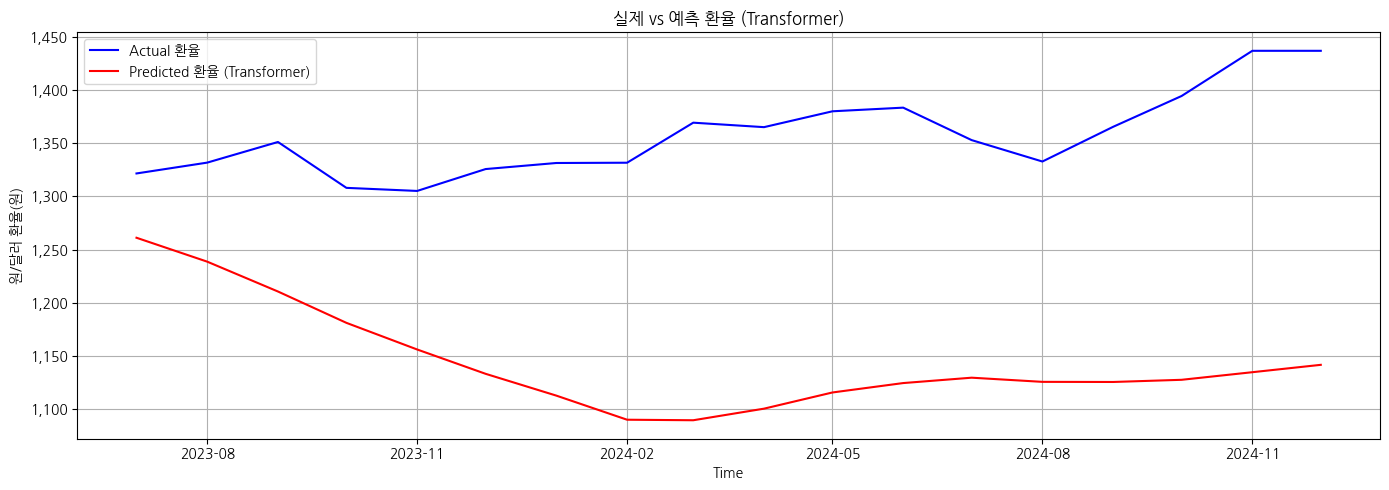

In [155]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (Transformer)", color='red')

# x축: 연도 + 월 표시
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (Transformer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 후진 제거법

In [239]:
# 피처 리스트
feature_cols = selected_backward
target_col = '원/달러환율_t+1'
seq_length = 12

# 시퀀스 데이터 생성
X_train_seq, y_train_seq = create_sequences(train_scaled, feature_cols, target_col, seq_length)
X_val_seq, y_val_seq = create_sequences(val_scaled, feature_cols, target_col, seq_length)
X_test_seq, y_test_seq = create_sequences(test_scaled, feature_cols, target_col, seq_length)

### 기본 모델

In [240]:
# 기본 Mini-Transformer
model = build_basic_transformer(input_shape=(seq_length, len(feature_cols)))

# EarlyStopping 설정
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 학습
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 2.6152 - root_mean_squared_error: 1.5884 - val_loss: 0.3967 - val_root_mean_squared_error: 0.6299
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3760 - root_mean_squared_error: 0.6110 - val_loss: 0.1344 - val_root_mean_squared_error: 0.3666
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2683 - root_mean_squared_error: 0.5122 - val_loss: 0.2987 - val_root_mean_squared_error: 0.5466
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1410 - root_mean_squared_error: 0.3748 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2078
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0602 - root_mean_squared_error: 0.2438 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1987
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0336 - root_mean_squared_error: 0.1823 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2630
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0231

- 예측/ 역변환

In [241]:
# 예측 (스케일된 상태)
y_pred_scaled = model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

# MinMaxScaler 역변환
total_feature_count = scaler.n_features_in_

y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


In [242]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

✅ RMSE: 80.8317
✅ MAE : 67.5253
✅ MSE : 6533.7612
✅ R²  : -3.6052


In [243]:
# 🔁 검증셋 예측
y_val_pred_scaled = model.predict(X_val_seq).flatten()

# 🔁 검증셋 역변환
y_val_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_val_pred_scaled), total_feature_count - 1)), y_val_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_val_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_val_seq), total_feature_count - 1)), y_val_seq.reshape(-1, 1)])
)[:, -1]

# 📊 성능 지표 계산
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
val_mae = mean_absolute_error(y_val_true, y_val_pred)
val_mse = mean_squared_error(y_val_true, y_val_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

print(f"📊 검증 RMSE: {val_rmse:.4f}")
print(f"📊 검증 MAE : {val_mae:.4f}")
print(f"📊 검증 MSE : {val_mse:.4f}")
print(f"📊 검증 R²  : {val_r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
📊 검증 RMSE: 53.3753
📊 검증 MAE : 47.3986
📊 검증 MSE : 2848.9229
📊 검증 R²  : -0.2550


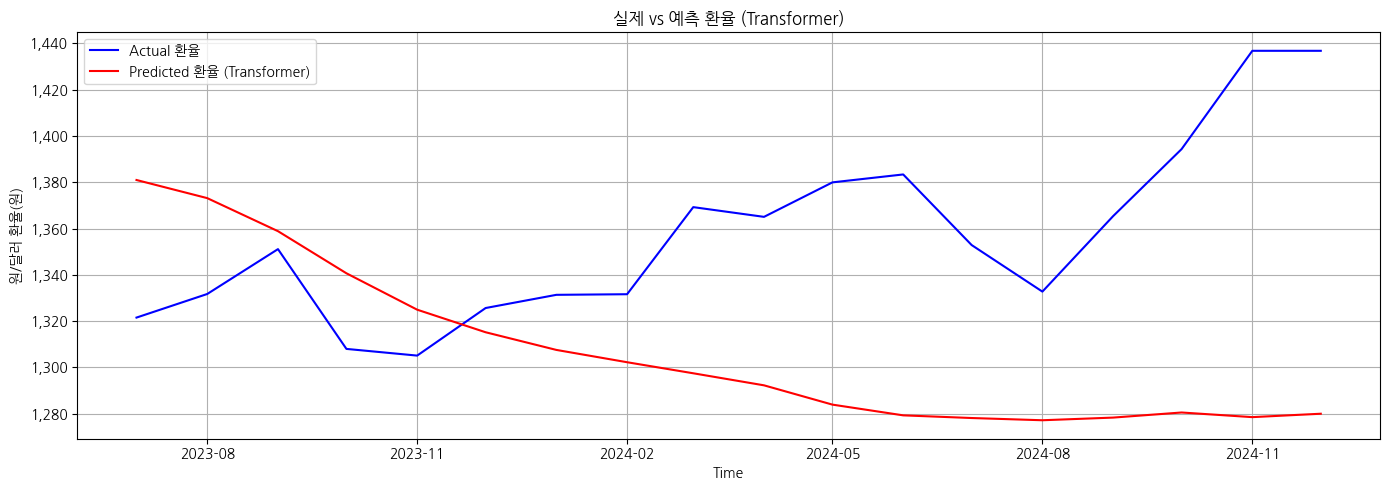

In [167]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (Transformer)", color='red')

# x축: 연도 + 월 표시
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (Transformer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### OPTUNA

In [170]:
import optuna
from tensorflow.keras import layers, models

# Optuna 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# 결과 출력
print("✅ Best params:", study.best_params)
print("✅ Best RMSE (val):", study.best_value)


[I 2025-04-29 16:03:42,125] A new study created in memory with name: no-name-3f240dd0-e971-4148-99af-a16cc725c51c
[I 2025-04-29 16:03:55,249] Trial 0 finished with value: 0.15963420271873474 and parameters: {'num_heads': 3, 'key_dim': 57, 'ff_units': 33, 'dropout': 0.20889557655847663, 'learning_rate': 0.0001841657012692718, 'batch_size': 64}. Best is trial 0 with value: 0.15963420271873474.
[I 2025-04-29 16:04:03,831] Trial 1 finished with value: 0.14939787983894348 and parameters: {'num_heads': 1, 'key_dim': 10, 'ff_units': 108, 'dropout': 0.23318382158430487, 'learning_rate': 0.0002156078913801557, 'batch_size': 64}. Best is trial 1 with value: 0.14939787983894348.
[I 2025-04-29 16:04:10,419] Trial 2 finished with value: 0.12439271807670593 and parameters: {'num_heads': 3, 'key_dim': 48, 'ff_units': 83, 'dropout': 0.4094106487503273, 'learning_rate': 0.0007926641553468333, 'batch_size': 64}. Best is trial 2 with value: 0.12439271807670593.
[I 2025-04-29 16:04:21,788] Trial 3 finishe

✅ Best params: {'num_heads': 4, 'key_dim': 63, 'ff_units': 61, 'dropout': 0.4947470257191492, 'learning_rate': 0.008681792682481104, 'batch_size': 32}
✅ Best RMSE (val): 0.09179922193288803


In [171]:
best_params = study.best_params

# 최종 모델 구성
def build_best_transformer(input_shape, params):
    set_seed(42)

    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    x = layers.LayerNormalization()(x)

    # Multi-head Attention
    attn = layers.MultiHeadAttention(
        num_heads=params['num_heads'],
        key_dim=params['key_dim']
    )(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Feed Forward → residual 연결 위한 shape 정합
    ff = layers.Dense(x.shape[-1], activation='relu')(x)
    ff = layers.Dropout(params['dropout'])(ff)
    x = layers.Add()([x, ff])

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

final_model = build_best_transformer(input_shape=(seq_length, len(feature_cols)), params=best_params)

history = final_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 22.3420 - root_mean_squared_error: 4.4606 - val_loss: 5.9540 - val_root_mean_squared_error: 2.4401
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.0436 - root_mean_squared_error: 1.3979 - val_loss: 0.4093 - val_root_mean_squared_error: 0.6398
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3454 - root_mean_squared_error: 0.5861 - val_loss: 0.0822 - val_root_mean_squared_error: 0.2866
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2086 - root_mean_squared_error: 0.4565 - val_loss: 0.0693 - val_root_mean_squared_error: 0.2633
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1786 - root_mean_squared_error: 0.4223 - val_loss: 0.1284 - val_root_mean_squared_error: 0.3584
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0933 - root_mean_squared_error: 0.3053 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1315 - roo

In [172]:
# 예측 (스케일된 상태)
y_pred_scaled = final_model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

# MinMaxScaler 역변환
total_feature_count = scaler.n_features_in_

y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


In [173]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

✅ RMSE: 181.0517
✅ MAE : 176.5239
✅ MSE : 32779.7248
✅ R²  : -22.1043


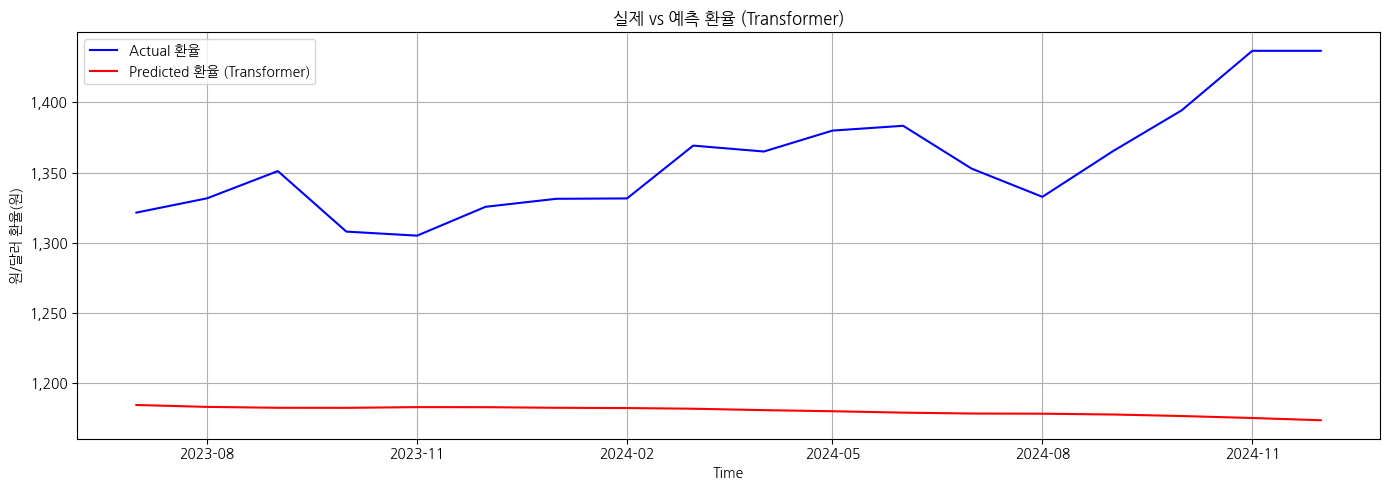

In [174]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (Transformer)", color='red')

# x축: 연도 + 월 표시
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (Transformer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 단계 선택법

In [234]:
# 피처 리스트
feature_cols = selected_stepwise
target_col = '원/달러환율_t+1'
seq_length = 12

# 시퀀스 데이터 생성
X_train_seq, y_train_seq = create_sequences(train_scaled, feature_cols, target_col, seq_length)
X_val_seq, y_val_seq = create_sequences(val_scaled, feature_cols, target_col, seq_length)
X_test_seq, y_test_seq = create_sequences(test_scaled, feature_cols, target_col, seq_length)

### 기본모델

In [235]:
# 기본 Mini-Transformer
model = build_basic_transformer(input_shape=(seq_length, len(feature_cols)))

# EarlyStopping 설정
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 학습
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.4518 - root_mean_squared_error: 0.6670 - val_loss: 0.4844 - val_root_mean_squared_error: 0.6960
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2061 - root_mean_squared_error: 0.4502 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2417
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0853 - root_mean_squared_error: 0.2916 - val_loss: 0.0752 - val_root_mean_squared_error: 0.2743
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0413 - root_mean_squared_error: 0.2033 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1627
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0228 - root_mean_squared_error: 0.1500 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1851
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0199 - root_mean_squared_error: 0.1403 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1605
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0153 - root

In [236]:
# 예측 (스케일된 상태)
y_pred_scaled = model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

# MinMaxScaler 역변환
total_feature_count = scaler.n_features_in_

y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


In [237]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

✅ RMSE: 114.7361
✅ MAE : 112.0215
✅ MSE : 13164.3721
✅ R²  : -8.2787


In [238]:
# 🔁 검증셋 예측
y_val_pred_scaled = model.predict(X_val_seq).flatten()

# 🔁 검증셋 역변환
y_val_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_val_pred_scaled), total_feature_count - 1)), y_val_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_val_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_val_seq), total_feature_count - 1)), y_val_seq.reshape(-1, 1)])
)[:, -1]

# 📊 성능 지표 계산
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
val_mae = mean_absolute_error(y_val_true, y_val_pred)
val_mse = mean_squared_error(y_val_true, y_val_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

print(f"📊 검증 RMSE: {val_rmse:.4f}")
print(f"📊 검증 MAE : {val_mae:.4f}")
print(f"📊 검증 MSE : {val_mse:.4f}")
print(f"📊 검증 R²  : {val_r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
📊 검증 RMSE: 82.7024
📊 검증 MAE : 69.8765
📊 검증 MSE : 6839.6915
📊 검증 R²  : -2.0131


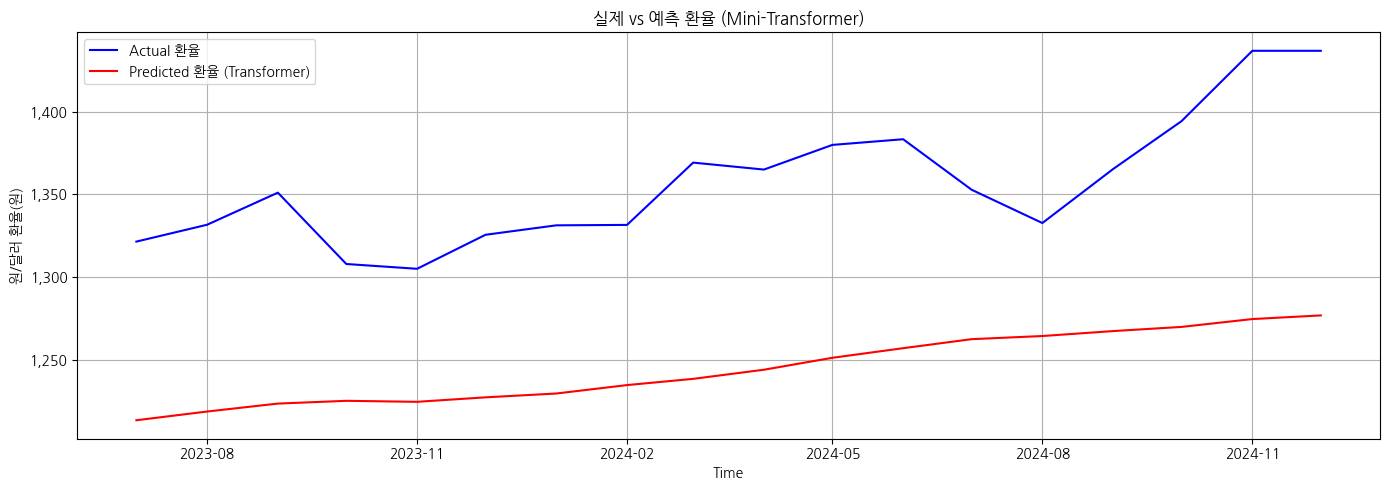

In [179]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (Transformer)", color='red')

# x축: 연도 + 월 표시
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (Mini-Transformer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### OPTUNA

In [180]:
import optuna
from tensorflow.keras import layers, models

# 튜닝용 Transformer 모델
def build_transformer_model(trial, input_shape):
    set_seed(42)

    num_heads = trial.suggest_int('num_heads', 1, 4)
    key_dim = trial.suggest_int('key_dim', 8, 64)
    ff_units = trial.suggest_int('ff_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    x = layers.LayerNormalization()(x)

    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ff = layers.Dense(x.shape[-1], activation='relu')(x)
    ff = layers.Dropout(dropout_rate)(ff)
    x = layers.Add()([x, ff])

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

# Optuna Objective
def objective(trial):
    model = build_transformer_model(trial, input_shape=(seq_length, len(feature_cols)))

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    _, val_rmse = model.evaluate(X_val_seq, y_val_seq, verbose=0)
    return val_rmse

# Optuna 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# 결과 출력
print("✅ Best params:", study.best_params)
print("✅ Best RMSE (val):", study.best_value)

[I 2025-04-29 16:16:42,670] A new study created in memory with name: no-name-7b2dc926-4296-447d-864f-8dbe0d9fa985
[I 2025-04-29 16:16:53,661] Trial 0 finished with value: 0.15852728486061096 and parameters: {'num_heads': 4, 'key_dim': 59, 'ff_units': 50, 'dropout': 0.30617362730014896, 'learning_rate': 0.004829382061266959, 'batch_size': 16}. Best is trial 0 with value: 0.15852728486061096.
[I 2025-04-29 16:17:03,446] Trial 1 finished with value: 0.13843661546707153 and parameters: {'num_heads': 2, 'key_dim': 45, 'ff_units': 41, 'dropout': 0.22269760254159038, 'learning_rate': 0.00111694873498101, 'batch_size': 16}. Best is trial 1 with value: 0.13843661546707153.
[I 2025-04-29 16:17:15,473] Trial 2 finished with value: 0.18524785339832306 and parameters: {'num_heads': 3, 'key_dim': 64, 'ff_units': 84, 'dropout': 0.42215990449052454, 'learning_rate': 0.0005620784942445969, 'batch_size': 64}. Best is trial 1 with value: 0.13843661546707153.
[I 2025-04-29 16:17:28,837] Trial 3 finished w

✅ Best params: {'num_heads': 3, 'key_dim': 34, 'ff_units': 71, 'dropout': 0.10205714158567913, 'learning_rate': 0.0014883614916483027, 'batch_size': 16}
✅ Best RMSE (val): 0.07394593209028244


In [181]:
best_params = study.best_params

# 최종 모델 구성
def build_best_transformer(input_shape, params):
    set_seed(42)

    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    x = layers.LayerNormalization()(x)

    # Multi-head Attention
    attn = layers.MultiHeadAttention(
        num_heads=params['num_heads'],
        key_dim=params['key_dim']
    )(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Feed Forward → residual 연결 위한 shape 정합
    ff = layers.Dense(x.shape[-1], activation='relu')(x)
    ff = layers.Dropout(params['dropout'])(ff)
    x = layers.Add()([x, ff])

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

final_model = build_best_transformer(input_shape=(seq_length, len(feature_cols)), params=best_params)

history = final_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.7344 - root_mean_squared_error: 0.8507 - val_loss: 0.1643 - val_root_mean_squared_error: 0.4053
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1679 - root_mean_squared_error: 0.4090 - val_loss: 0.0746 - val_root_mean_squared_error: 0.2731
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0817 - root_mean_squared_error: 0.2852 - val_loss: 0.1245 - val_root_mean_squared_error: 0.3528
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0589 - root_mean_squared_error: 0.2423 - val_loss: 0.0493 - val_root_mean_squared_error: 0.2220
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0370 - root_mean_squared_error: 0.1905 - val_loss: 0.1010 - val_root_mean_squared_error: 0.3178
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0322 - root_mean_squared_error: 0.1789 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1669
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss:

In [182]:
# 예측 (스케일된 상태)
y_pred_scaled = final_model.predict(X_test_seq).flatten()
y_true_scaled = y_test_seq

# MinMaxScaler 역변환
total_feature_count = scaler.n_features_in_

y_pred = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_scaled), total_feature_count - 1)), y_pred_scaled.reshape(-1, 1)])
)[:, -1]

y_true = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_true_scaled), total_feature_count - 1)), y_true_scaled.reshape(-1, 1)])
)[:, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


In [183]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ R²  : {r2:.4f}")

✅ RMSE: 123.2973
✅ MAE : 107.9181
✅ MSE : 15202.2157
✅ R²  : -9.7151


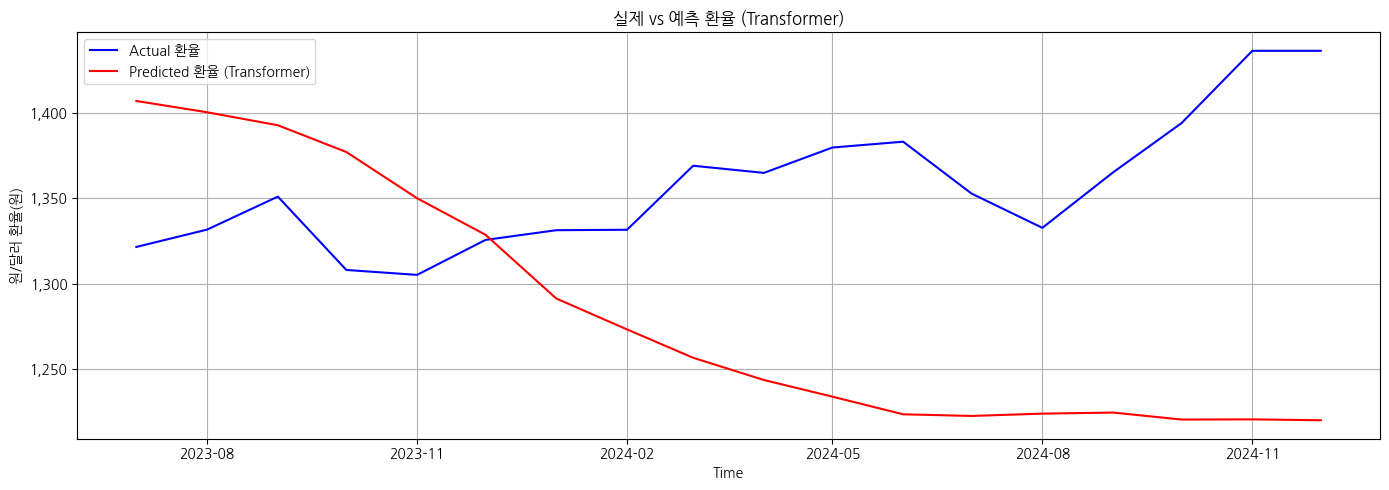

In [184]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# 시계열 x축 준비
time_index = pd.to_datetime(test_scaled['TIME'].values[seq_length:])

plt.figure(figsize=(14, 5))
plt.plot(time_index, y_true, label="Actual 환율", color='blue')
plt.plot(time_index, y_pred, label="Predicted 환율 (Transformer)", color='red')

# x축: 연도 + 월 표시
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# y축: 천 단위 컴마
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel("Time")
plt.ylabel("원/달러 환율(원)")
plt.title("실제 vs 예측 환율 (Transformer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 과적합 여부 판단


1. 학습 vs 검증 손실 추이	val_loss가 일정 시점 이후 증가하는데 loss는 계속 감소하면 과적합 가능성 ↑
2. EarlyStopping 동작	복원 시점이 초반(=best epoch << max epoch) 이면 과적합 가능성 ↑
3. 검증 성능 vs 테스트 성능	검증 성능은 좋은데 테스트 성능이 급격히 나쁠 경우 과적합 가능성 ↑  -> 정확
4. 지표 단위 차이	RMSE ≠ val_root_mean_squared_error일 경우 → 역변환 전/후 값으로 인해 정확한 비교 필요